<a href="https://colab.research.google.com/github/Shyams728/copper_ml_project/blob/main/copper_price_prediction_and_leads_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Copper Price Prediction and Leads Classification

### Importing Libraries and Setting up the Notebook

In [ ]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_score, recall_score, confusion_matrix, classification_report
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from cuml.linear_model import LinearRegression, LogisticRegression, Lasso, Ridge, ElasticNet
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor
from cuml.ensemble import RandomForestRegressor, RandomForestClassifier
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from cuml.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.naive_bayes import GaussianNB
from scipy.stats import chi2_contingency
from sklearn.decomposition import PCA
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import category_encoders as ce
from cuml.svm import SVC, SVR
import seaborn as sns
import pandas as pd
import numpy as np
import joblib

pd.pandas.set_option('display.max_columns',None)
sns.set_theme()
%matplotlib inline

### Reading Data and Knowing the Primaries

In [ ]:
df = pd.read_csv('/kaggle/input/copper/Copper.csv')
df.head()

,id,item_date,quantity tons,customer,country,status,item type,application,thickness,width,material_ref,product_ref,delivery date,selling_price
0,EC06F063-9DF0-440C-8764-0B0C05A4F6AE,20210401.0,54.151139,30156308.0,28.0,Won,W,10.0,2.00,1500.0,DEQ1 S460MC,1670798778,20210701.0,854.00
1,4E5F4B3D-DDDF-499D-AFDE-A3227EC49425,20210401.0,768.024839,30202938.0,25.0,Won,W,41.0,0.80,1210.0,0000000000000000000000000000000000104991,1668701718,20210401.0,1047.00
2,E140FF1B-2407-4C02-A0DD-780A093B1158,20210401.0,386.127949,30153963.0,30.0,Won,WI,28.0,0.38,952.0,S0380700,628377,20210101.0,644.33
3,F8D507A0-9C62-4EFE-831E-33E1DA53BB50,20210401.0,202.411065,30349574.0,32.0,Won,S,59.0,2.30,1317.0,DX51D+ZM310MAO 2.3X1317,1668701718,20210101.0,768.00
4,4E1C4E78-152B-430A-8094-ADD889C9D0AD,20210401.0,785.526262,30211560.0,28.0,Won,W,10.0,4.00,2000.0,2_S275JR+AR-CL1,640665,20210301.0,577.00


Column names seems to have space in between words... Let's replace space with underscore for convenience of calling...

In [ ]:
df.columns = [column.replace(' ', '_') for column in df.columns]
df.rename({'customer': 'customer_id', 'country': 'country_code'}, axis=1, inplace=True)

In [ ]:
df.columns

Index(['id', 'item_date', 'quantity_tons', 'customer_id', 'country_code',
       'status', 'item_type', 'application', 'thickness', 'width',
       'material_ref', 'product_ref', 'delivery_date', 'selling_price'],
      dtype='object')

In [ ]:
df.shape

(181673, 14)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181673 entries, 0 to 181672
Data columns (total 14 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   id             181671 non-null  object 
 1   item_date      181672 non-null  float64
 2   quantity_tons  181673 non-null  object 
 3   customer_id    181672 non-null  float64
 4   country_code   181645 non-null  float64
 5   status         181671 non-null  object 
 6   item_type      181673 non-null  object 
 7   application    181649 non-null  float64
 8   thickness      181672 non-null  float64
 9   width          181673 non-null  float64
 10  material_ref   103754 non-null  object 
 11  product_ref    181673 non-null  int64  
 12  delivery_date  181672 non-null  float64
 13  selling_price  181672 non-null  float64
dtypes: float64(8), int64(1), object(5)
memory usage: 19.4+ MB


In [ ]:
df.duplicated().sum()

0

In [ ]:
df.isnull().sum()

id                   2
item_date            1
quantity_tons        0
customer_id          1
country_code        28
status               2
item_type            0
application         24
thickness            1
width                0
material_ref     77919
product_ref          0
delivery_date        1
selling_price        1
dtype: int64

### Managing some basic inconsistencies

`id` column doesn't hold any value... So,  lets drop it straightaway...

In [ ]:
df.drop('id', axis = 1, inplace = True)

`quantity_tons` column has object dtype while it should actually be float... Let's change it...

In [ ]:
try:
    df['quantity_tons'] =  df['quantity_tons'].astype('float64')
except Exception as e:
    print(f'An Error Occurred: {e}')

An Error Occurred: could not convert string to float: 'e'


There seems to be some actual string within this column which is stopping the column from getting converted to float... Let's handle it...

In [ ]:
df['quantity_tons'] = pd.to_numeric(df['quantity_tons'], errors='coerce')

df['quantity_tons'].isnull().sum()

1

Let's handle this null value later...

Let's change the datatype of temporal variables to Datetime now as they are framed as float dtype

In [ ]:
print(df['item_date'].min(), '\n', df['item_date'].max())

19950000.0 
 20210401.0


There seems to be some inconsistency in the data... The lower ceiling is 1991(way out of the boundary) and date and month can't be 00.... We will coerce and make those NaT and then probably will see null count and see what to do with them...

In [ ]:
df['item_date'] = pd.to_datetime(df['item_date'], format='%Y%m%d', errors='coerce')

In [ ]:
print(df['item_date'].min(), '\n', df['item_date'].max())

2020-07-02 00:00:00 
 2021-04-01 00:00:00


In [ ]:
print(df['delivery_date'].min(), '\n', df['delivery_date'].max())

20190401.0 
 30310101.0


There seems to be some inconsistency in the data... The upper ceiling is 3031 which can't be the year for item date.... We will coerce and make it NaT and then probably will see null count and see what to do with it...

In [ ]:
df['delivery_date'] = pd.to_datetime(df['delivery_date'], format='%Y%m%d', errors='coerce')

In [ ]:
print(df['delivery_date'].min(), '\n', df['delivery_date'].max())

2019-04-01 00:00:00 
 2022-01-01 00:00:00


There seems to be mismatch between item date and delivery date... While delivery date min value is somewhere in 2019, item date min value starts from 2020 only.... Let's explore this further later on...

In [ ]:
item_year_counts = df['item_date'].dt.year.value_counts().sort_index()
print("\nItem Date Value Counts by Year:")
print(item_year_counts)

delivery_year_counts = df['delivery_date'].dt.year.value_counts().sort_index()
print("Delivery Date Value Counts by Year:")
print(delivery_year_counts)


Item Date Value Counts by Year:
2020.0    110777
2021.0     70893
Name: item_date, dtype: int64
Delivery Date Value Counts by Year:
2019.0         5
2020.0     59036
2021.0    122623
2022.0         6
Name: delivery_date, dtype: int64


In [ ]:
before_date = '2020-07-02 00:00:00'
df_before = df[df['delivery_date'] < before_date]
df_after = df[df['delivery_date'] >= before_date]

before_counts = df_before['delivery_date'].dt.year.value_counts().sort_index()
after_counts = df_after['delivery_date'].dt.year.value_counts().sort_index()

print("Delivery Date Value Counts Before {}: \n{}".format(before_date, before_counts))
print("\nDelivery Date Value Counts After {}: \n{}".format(before_date, after_counts))

Delivery Date Value Counts Before 2020-07-02 00:00:00: 
2019       5
2020    7940
Name: delivery_date, dtype: int64

Delivery Date Value Counts After 2020-07-02 00:00:00: 
2020     51096
2021    122623
2022         6
Name: delivery_date, dtype: int64


Let's see unique values to know whether there are anymore inconsistency in data...

In [ ]:
def unique_values(df, exclude_cols=[]):
    for col in df.columns:
        if col in exclude_cols:
            continue
        unique_vals = df[col].nunique()
        print(f"{col}: {unique_vals} unique values")
        if unique_vals < 35:
            print()
            print(df[col].unique())
        print("\n", 55 * "_", "\n")

In [ ]:
unique_values(df)

item_date: 250 unique values

 _______________________________________________________ 

quantity_tons: 181672 unique values

 _______________________________________________________ 

customer_id: 1169 unique values

 _______________________________________________________ 

country_code: 17 unique values

[ 28.  25.  30.  32.  38.  78.  27.  77. 113.  79.  26.  39.  40.  84.
  80. 107.  89.  nan]

 _______________________________________________________ 

status: 9 unique values

['Won' 'Draft' 'To be approved' 'Lost' 'Not lost for AM' 'Wonderful'
 'Revised' 'Offered' 'Offerable' nan]

 _______________________________________________________ 

item_type: 7 unique values

['W' 'WI' 'S' 'Others' 'PL' 'IPL' 'SLAWR']

 _______________________________________________________ 

application: 30 unique values

[10. 41. 28. 59. 15.  4. 38. 56. 42. 26. 27. 19. 20. 66. 29. 22. 40. 25.
 67. 79.  3. 99.  2.  5. 39. 69. 70. 65. 58. 68. nan]

 _______________________________________________________

`customer_id`, `country_code`, `application`, `material_ref`, `product_ref` columns has customer ids, country codes, where copper is going to be used, some unique values representing that specific product and material the product has been made up of all in float dtype while they should actually be considered categorical variables... We would be changing them to object dtype and then would do encoding later on when we handle categorical data...

In `status` column we would just need `won` or `lost`... So, we would drop all other instances...

`item_type` column has 7 unique values and it would be encoded later on while handling cat vars...

Other than these nothing looks to be problematic as of now...

Let's first change dtype of those 5 columns

In [ ]:
columns_to_convert = ['customer_id', 'country_code', 'application', 'material_ref', 'product_ref']

for column in columns_to_convert:
    df[column] = df[column].astype(str)
    df[column] = df[column].replace('\.0', '', regex=True)

Let's trim the dataset and have just those instances which has either `won` or `lost` in status column and then let's rename the column as `leads`...

In [ ]:
df['status'].value_counts()

Won                116010
Lost                34438
Not lost for AM     19573
Revised              4276
To be approved       4170
Draft                3140
Offered                53
Offerable              10
Wonderful               1
Name: status, dtype: int64

In [ ]:
df = df[df['status'].isin(['Won', 'Lost'])]
df.rename({'status': 'leads'}, axis=1, inplace=True)

In [ ]:
df['leads'].value_counts()

Won     116010
Lost     34438
Name: leads, dtype: int64

Has imbalance... Let's handle it later while building the model...

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150448 entries, 0 to 181672
Data columns (total 13 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   item_date      150445 non-null  datetime64[ns]
 1   quantity_tons  150447 non-null  float64       
 2   customer_id    150448 non-null  object        
 3   country_code   150448 non-null  object        
 4   leads          150448 non-null  object        
 5   item_type      150448 non-null  object        
 6   application    150448 non-null  object        
 7   thickness      150448 non-null  float64       
 8   width          150448 non-null  float64       
 9   material_ref   150448 non-null  object        
 10  product_ref    150448 non-null  object        
 11  delivery_date  150446 non-null  datetime64[ns]
 12  selling_price  150447 non-null  float64       
dtypes: datetime64[ns](2), float64(4), object(7)
memory usage: 16.1+ MB


Datatypes and some basic inconsistencies has got addressed... Lets, handle null values and outliers now...

In [ ]:
df.isnull().sum()

item_date        3
quantity_tons    1
customer_id      0
country_code     0
leads            0
item_type        0
application      0
thickness        0
width            0
material_ref     0
product_ref      0
delivery_date    2
selling_price    1
dtype: int64

We could have considered some kinda imputation if the proportion of null value is large. But, as they are of negligible amount and as the dataset is pretty large, let's drop null values here...

In [ ]:
df.dropna(inplace=True)

Now that the missing values are handled, let's check for outliers, distribution and range of continuous variables

In [ ]:
df.nunique()

item_date           248
quantity_tons    150441
customer_id        1125
country_code         18
leads                 2
item_type             7
application          31
thickness           569
width              1347
material_ref      15821
product_ref          32
delivery_date        25
selling_price      8943
dtype: int64

Based on data we have and after considering the unique values and dtype of columns.... We can categorize our columns like below...

Categorical Nominal Variables - `customer_id`, `country_code`, `leads`, `item_type`, `application`, `material_ref`, `product_ref`

Continuous Variables - `quantity_tons`, `thickness`, `width`, `selling_price`

Temporal Variables - `item_date`, `delivery_date`

### Handling Temporal Variables

We have noted some inconsistency between item date and delivery date... Let's explore it further...

In [ ]:
item_year_counts = df['item_date'].dt.year.value_counts().sort_index()
print("\nItem Date Value Counts by Year:")
print(item_year_counts)

delivery_year_counts = df['delivery_date'].dt.year.value_counts().sort_index()
print("Delivery Date Value Counts by Year:")
print(delivery_year_counts)


Item Date Value Counts by Year:
2020    92068
2021    58373
Name: item_date, dtype: int64
Delivery Date Value Counts by Year:
2019         3
2020     49343
2021    101089
2022         6
Name: delivery_date, dtype: int64


As we can clearly see delivery dates can't be before item date (provided item date is something like auction date)... So, there could be either of the following two possible reasons behind this inconsistency...

1. Data entry error if 3 entries in `2019` alone has got entered wrongly and nothing before the min `item_date` in `2020` or negligible instances before  the min `item_date` in `2020`...

2. `item_date` could be something totally unrelated to `delivery_date` if significant proportion of data in `2020` falls before the min `item_date` in `2020`... In such case we would be dropping both dates as they won't be useful to build either of regression or classification model standalone...

Now, let's dig deep to know whether there are significant no. of data points in `delivery_date` falling behind  the min `item_date` in `2020`...

In [ ]:
before_date = '2020-07-02 00:00:00'  #  the min "item_date"...

df_before = df[df['delivery_date'] < before_date]
df_after = df[df['delivery_date'] >= before_date]

before_counts = df_before['delivery_date'].dt.year.value_counts().sort_index()
after_counts = df_after['delivery_date'].dt.year.value_counts().sort_index()

print("Delivery Date Value Counts Before {}: \n{}".format(before_date, before_counts))
print("\nDelivery Date Value Counts After {}: \n{}".format(before_date, after_counts))

Delivery Date Value Counts Before 2020-07-02 00:00:00: 
2019       3
2020    7295
Name: delivery_date, dtype: int64

Delivery Date Value Counts After 2020-07-02 00:00:00: 
2020     42048
2021    101089
2022         6
Name: delivery_date, dtype: int64


Text(0.5, 1.0, 'Selling Price vs Delivery Date')

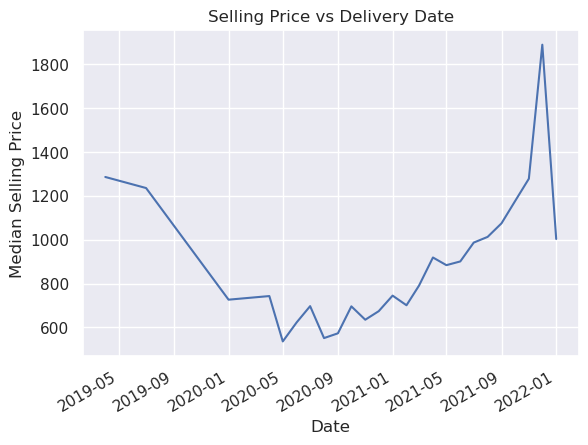

In [ ]:
df.groupby('delivery_date')['selling_price'].median().plot()
plt.xlabel('Date')
plt.ylabel('Median Selling Price')
plt.title("Selling Price vs Delivery Date")

This holds no value as it is not representing any proportional insight.... We would drop this...

Text(0.5, 1.0, 'Selling Price vs Item Date')

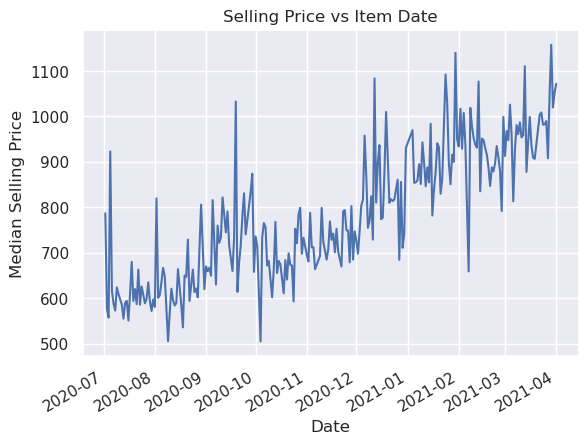

In [ ]:
df.groupby('item_date')['selling_price'].median().plot()
plt.xlabel('Date')
plt.ylabel('Median Selling Price')
plt.title("Selling Price vs Item Date")

This as well doesn't hold much value as it is so instable in delivering any insight as time progresses.... No steady rise or fall can be observed over here and we can't observe any seasonal pattern as well with the limited data(Jul 2020 to Apr 2021) that we have... So, it would be ideal if we drop both these date columns and move forward with other features...

In [ ]:
df.drop(['item_date', 'delivery_date'], axis=1, inplace=True)

### Splitting Data into Categorical and Continuous

In [ ]:
categorical_vars = []
continuous_vars = []

for col in df.columns:

    unique_values = df[col].nunique()

    if df[col].dtype == 'object':
        categorical_vars.append(col)
    else:
        continuous_vars.append(col)

print("Categorical Variables:\n")
print(categorical_vars)
print("\n", 100 * "_", "\n")
print("Continuous Variables:\n")
print(continuous_vars)

Categorical Variables:

['customer_id', 'country_code', 'leads', 'item_type', 'application', 'material_ref', 'product_ref']

 ____________________________________________________________________________________________________ 

Continuous Variables:

['quantity_tons', 'thickness', 'width', 'selling_price']


### Handling Continuous Variables

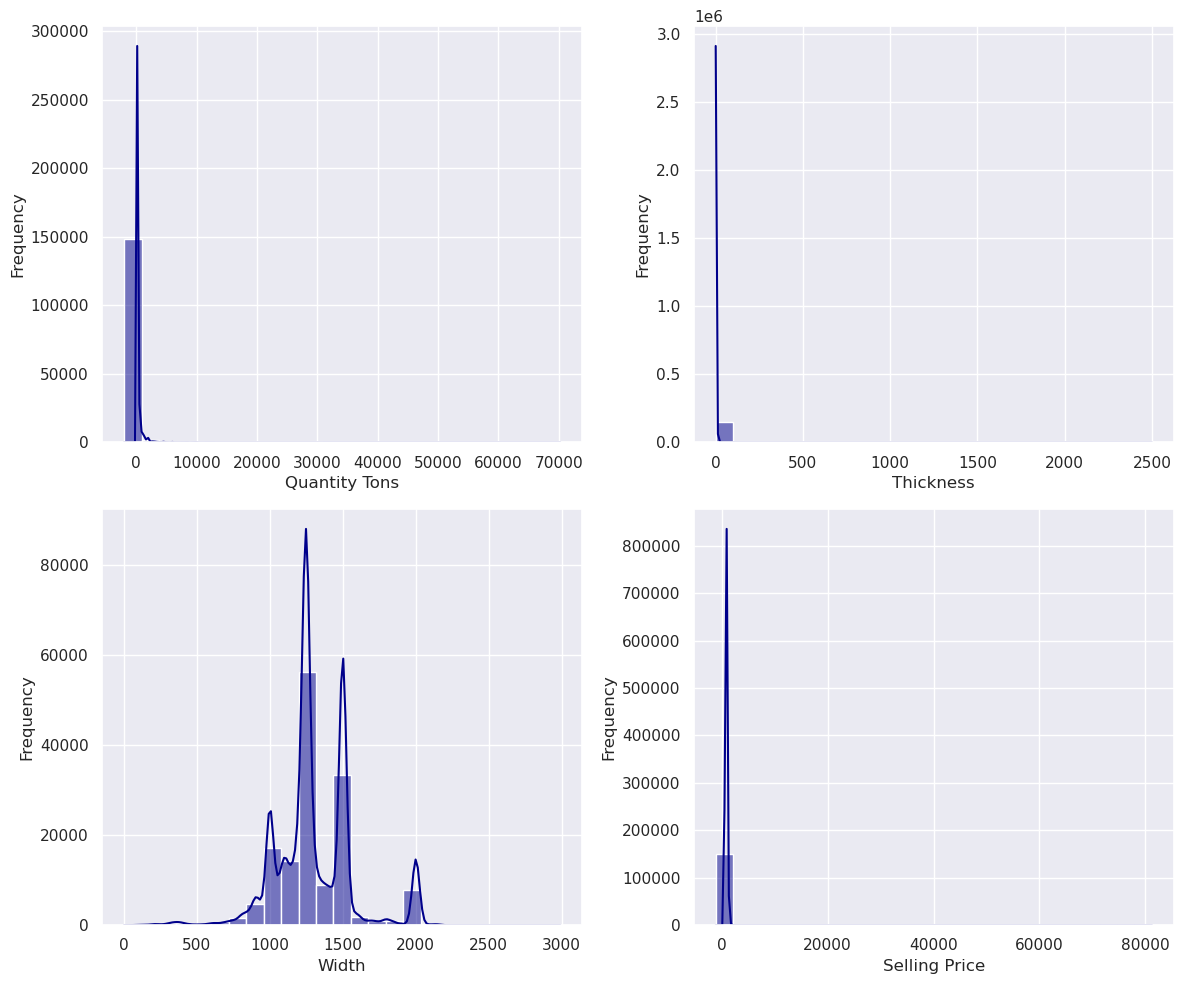

In [ ]:
num_plots = len(continuous_vars)

num_rows = (num_plots + 1) // 2  # Number of rows for subplots

fig, axes = plt.subplots(num_rows, 2, figsize=(12, 5 * num_rows))

for i, feature in enumerate(continuous_vars):

    data = df.copy()

    row = i // 2
    col = i % 2
    ax = axes[row, col]

    sns.histplot(data[feature], ax=ax, bins=25, kde=True, color='darkblue')
    ax.set_xlabel(feature.replace('_', ' ').title())
    ax.set_ylabel("Frequency")

# Remove any empty subplots
if num_plots < num_rows * 2:
    fig.delaxes(axes[num_rows-1, 1])

plt.tight_layout()
plt.show()

There seems to be outliers in 3 of the four columns making them right skewed distributions... Let's see how many outliers are there and then decide what we can do about them...

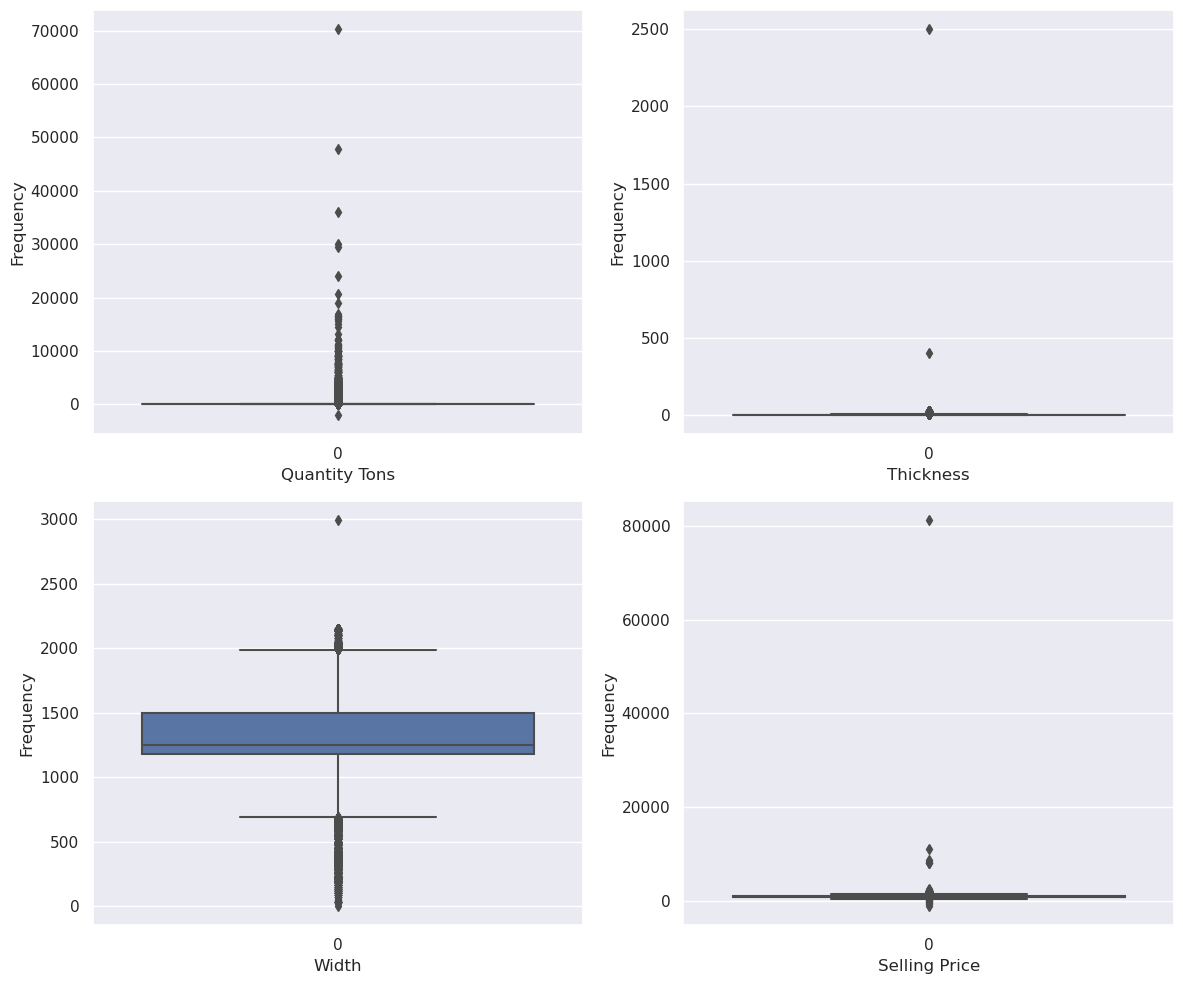

In [ ]:
num_plots = len(continuous_vars)

num_rows = (num_plots + 1) // 2  # Number of rows for subplots

fig, axes = plt.subplots(num_rows, 2, figsize=(12, 5 * num_rows))

for i, feature in enumerate(continuous_vars):

    data = df.copy()

    row = i // 2
    col = i % 2
    ax = axes[row, col]

    sns.boxplot(data[feature], ax=ax)
    ax.set_xlabel(feature.replace('_', ' ').title())
    ax.set_ylabel("Frequency")

# Remove any empty subplots
if num_plots < num_rows * 2:
    fig.delaxes(axes[num_rows-1, 1])

plt.tight_layout()
plt.show()

In [ ]:
def count_outliers(df):
    outliers = {}
    for col in df.select_dtypes(include='number').columns:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        upper_bound = q3 + (1.5 * iqr)
        lower_bound = q1 - (1.5 * iqr)
        num_outliers = len(df[(df[col] > upper_bound) | (df[col] < lower_bound)])
        percent_outliers = (num_outliers / len(df)) * 100
        outliers[col] = {'count': num_outliers, 'percent': percent_outliers}
    return outliers

In [ ]:
outliers = count_outliers(df)
for col, info in outliers.items():
    print(f"Column: {col}")
    print(f"Count of outliers: {info['count']}")
    print(f"Percentage of outliers: {round(info['percent'], 2)}%")
    print()

Column: quantity_tons
Count of outliers: 17577
Percentage of outliers: 11.68%

Column: thickness
Count of outliers: 11851
Percentage of outliers: 7.88%

Column: width
Count of outliers: 9564
Percentage of outliers: 6.36%

Column: selling_price
Count of outliers: 1342
Percentage of outliers: 0.89%



In [ ]:
continuous_vars

['quantity_tons', 'thickness', 'width', 'selling_price']

In [ ]:
data = df.copy()

data['quantity_tons'] = data['quantity_tons'].clip(upper=data['quantity_tons'].quantile(0.88), lower=data['quantity_tons'].quantile(0.01))
data['thickness'] = data['thickness'].clip(upper=data['thickness'].quantile(0.92))
data['width'] = data['width'].clip(upper=data['width'].quantile(0.94), lower=data['width'].quantile(0.02))
data['selling_price'] = data['selling_price'].clip(upper=data['selling_price'].quantile(0.99), lower=data['selling_price'].quantile(0.01))

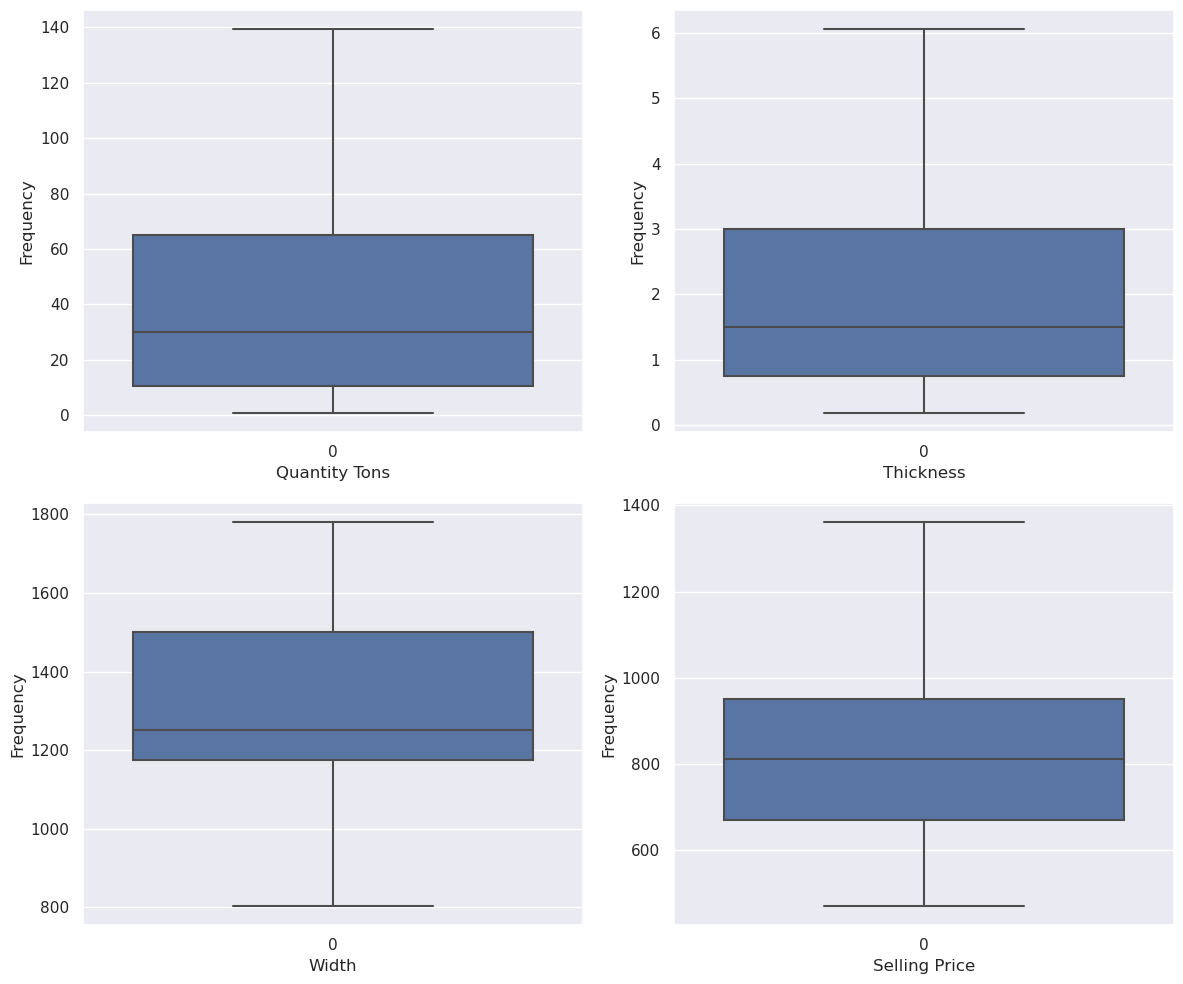

In [ ]:
num_plots = len(continuous_vars)

num_rows = (num_plots + 1) // 2  # Number of rows for subplots

fig, axes = plt.subplots(num_rows, 2, figsize=(12, 5 * num_rows))

for i, feature in enumerate(continuous_vars):

    row = i // 2
    col = i % 2
    ax = axes[row, col]

    sns.boxplot(data[feature], ax=ax)
    ax.set_xlabel(feature.replace('_', ' ').title())
    ax.set_ylabel("Frequency")

# Remove any empty subplots
if num_plots < num_rows * 2:
    fig.delaxes(axes[num_rows-1, 1])

plt.tight_layout()
plt.show()

Let's see range in which the data is distributed across all continuous variables and decide whether we have to scale it or not...

In [ ]:
def get_column_ranges(df):
    ranges = {}
    for column in continuous_vars:
        column_min = df[column].min()
        column_max = df[column].max()
        column_range = column_max - column_min
        ranges[column] = [column_min, column_max, column_range]
    return ranges

In [ ]:
ranges = get_column_ranges(data)

for column, values in ranges.items():
    print(f"Column: {column}")
    print(f"Minimum: {values[0]}, Maximum: {values[1]}, Range: {values[2]}")
    print()

Column: quantity_tons
Minimum: 0.77290697736, Maximum: 139.32285744, Range: 138.54995046264

Column: thickness
Minimum: 0.18, Maximum: 6.06, Range: 5.88

Column: width
Minimum: 803.0, Maximum: 1780.0, Range: 977.0

Column: selling_price
Minimum: 471.0, Maximum: 1361.0, Range: 890.0



As we can see, the min, max values and range across columns are varying a lot... So, we would do scaling later on inorder to bring all of them to a same scale... Now, let's move on towards categorical variables...

### Handling Categorical Variables

In [ ]:
categorical_vars

['customer_id',
 'country_code',
 'leads',
 'item_type',
 'application',
 'material_ref',
 'product_ref']

As we have already noticed, all of these are nominal columns...

In [ ]:
def unique_values(df, exclude_cols=[]):
    for col in df.columns:
        if col in exclude_cols:
            continue
        unique_vals = df[col].nunique()
        print(f"{col}: {unique_vals} unique values")
        if unique_vals < 35:
            print()
            print(df[col].unique())
        print("\n", 55 * "_", "\n")

unique_values(data, exclude_cols=continuous_vars)

customer_id: 1125 unique values

 _______________________________________________________ 

country_code: 18 unique values

['28' '25' '30' '32' '38' '78' '27' '77' '113' '79' '26' '39' '40' '84'
 '80' '89' 'nan' '107']

 _______________________________________________________ 

leads: 2 unique values

['Won' 'Lost']

 _______________________________________________________ 

item_type: 7 unique values

['W' 'WI' 'S' 'Others' 'PL' 'IPL' 'SLAWR']

 _______________________________________________________ 

application: 31 unique values

['10' '41' '28' '59' '15' '4' '38' '56' '42' '26' '27' '19' '20' '66' '29'
 '22' '25' '40' '79' '3' '99' '2' '67' '5' '39' '69' '70' '65' '58' '68'
 'nan']

 _______________________________________________________ 

material_ref: 15821 unique values

 _______________________________________________________ 

product_ref: 32 unique values

['1670798778' '1668701718' '628377' '640665' '611993' '1668701376'
 '164141591' '1671863738' '1332077137' '640405' '16

We can see that few columns where there are `NaN` values under the hood of `nan`... Also, we understood from the project assigner that `material_ref` column has few values starting with `00000` and those as well should be treated as null values... Let's handle these two first...

In [ ]:
data = data.replace('nan', np.nan)

In [ ]:
data.isnull().sum()

quantity_tons        0
customer_id          1
country_code         4
leads                0
item_type            0
application          3
thickness            0
width                0
material_ref     62793
product_ref          0
selling_price        0
dtype: int64

In [ ]:
count = (data['material_ref'].str.startswith('00000')).sum()

print(f"Number of values starting with '00000': {count}")

Number of values starting with '00000': 19619


In [ ]:
null_mat_ref = data.isnull().sum()['material_ref'] + count
null_mat_ref

82412

In [ ]:
percent_null_mat_ref = (null_mat_ref/len(data)) * 100
percent_null_mat_ref

54.7802793121556

As we can see, more than half of the data is filled with null values... We could have considered imputing values based on some methodology  if the proportion of null values is smaller... But, we can't impute majority of data using minor portion of available data which would probably lead to misleading output... So, it would be ideal to drop this column altogether...

**Note:** In a real world scenario, we should probably consult with client and decide on it whether we can proceed with imputation or dropping...

In [ ]:
data.drop('material_ref', axis=1, inplace=True)
categorical_vars.remove('material_ref')
categorical_vars

['customer_id',
 'country_code',
 'leads',
 'item_type',
 'application',
 'product_ref']

All other columns, let's use mode to impute values as they are of negligible proportion...

In [ ]:
data.fillna(data.mode().iloc[0], inplace=True)

In [ ]:
data.isnull().sum()

quantity_tons    0
customer_id      0
country_code     0
leads            0
item_type        0
application      0
thickness        0
width            0
product_ref      0
selling_price    0
dtype: int64

Having handled null values successfully, let's encode cat vars...

In [ ]:
unique_values(data, exclude_cols=continuous_vars)

customer_id: 1124 unique values

 _______________________________________________________ 

country_code: 17 unique values

['28' '25' '30' '32' '38' '78' '27' '77' '113' '79' '26' '39' '40' '84'
 '80' '89' '107']

 _______________________________________________________ 

leads: 2 unique values

['Won' 'Lost']

 _______________________________________________________ 

item_type: 7 unique values

['W' 'WI' 'S' 'Others' 'PL' 'IPL' 'SLAWR']

 _______________________________________________________ 

application: 30 unique values

['10' '41' '28' '59' '15' '4' '38' '56' '42' '26' '27' '19' '20' '66' '29'
 '22' '25' '40' '79' '3' '99' '2' '67' '5' '39' '69' '70' '65' '58' '68']

 _______________________________________________________ 

product_ref: 32 unique values

['1670798778' '1668701718' '628377' '640665' '611993' '1668701376'
 '164141591' '1671863738' '1332077137' '640405' '1693867550' '1665572374'
 '1282007633' '1668701698' '628117' '1690738206' '628112' '640400'
 '1671876026' '16

Let's first check correlation of categorical variables against the target variable...

In [ ]:
def calculate_correlation(df, categorical_vars, target_var):
    correlations = []
    for var in categorical_vars:
        crosstab = pd.crosstab(df[var], df[target_var])
        chi2, _, _, _ = chi2_contingency(crosstab)
        n = crosstab.sum().sum()
        phi = np.sqrt(chi2 / n)
        correlations.append((var, phi))

    return correlations

def plot_correlation(correlations, target_var):
    df_corr = pd.DataFrame(correlations, columns=['Variable', 'Correlation'])
    df_corr.sort_values(by='Correlation', inplace=True)

    fig, ax = plt.subplots(figsize=(8, 6))
    ax.barh(df_corr['Variable'], df_corr['Correlation'])
    ax.set_xlabel('Correlation')
    ax.set_ylabel('Variable')
    ax.set_title(f'Correlation between Categorical Variables and {target_var.title()}')
    plt.show()

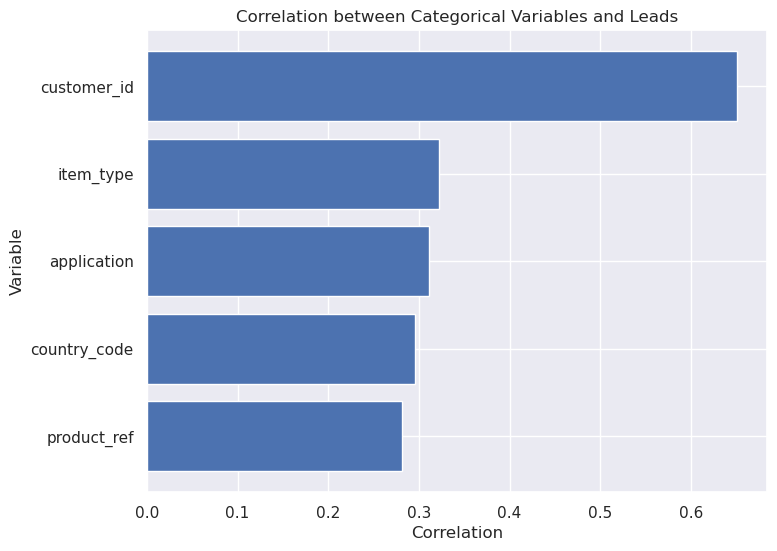

In [ ]:
temp_list = [var for var in categorical_vars if var != 'leads']

correlations = calculate_correlation(data, temp_list, 'leads')
plot_correlation(correlations, 'leads')

`leads` - Just `won` or `lost`. So, one hot encoding would be apt thing to do...

Now let's compare no. of unique values and the correlation with target column to decide which encoding technique we would be using for each of the categorical variables...

As we can see, apart from customer_id nothing else has much correlation with target... So, considering the high correlation and high cardinality, we would do `target encoding` over `customer_id` column...

All other columns we would choose type of encoding purely based on intuition, logical reasoning and the cardinality (no. of unique values)...

One Hot Encoding Columns:

Too many features encoded with target encoding would probably lead to overfitting... So, we would try to reduce the no. of columns getting target encoded... Considering this and based on few other intuition, we would go with OHE for `country_code` and `product_ref` columns apart from `leads`

Target encoding columns:

Let's use target_encoding over other two columns along with `customer_id`

In [ ]:
encoded_df = data.copy()

encoded_df = pd.get_dummies(encoded_df, columns=['leads', 'country_code', 'product_ref'], drop_first=True)

encoded_df.rename({'leads_Won':'leads'}, axis=1, inplace=True)

In [ ]:
encoded_df.shape

(150441, 55)

In [ ]:
encoded_df.head()

,quantity_tons,customer_id,item_type,application,thickness,width,selling_price,leads,country_code_113,country_code_25,country_code_26,country_code_27,country_code_28,country_code_30,country_code_32,country_code_38,country_code_39,country_code_40,country_code_77,country_code_78,country_code_79,country_code_80,country_code_84,country_code_89,product_ref_1332077137,product_ref_164141591,product_ref_164336407,product_ref_164337175,product_ref_1665572032,product_ref_1665572374,product_ref_1665584320,product_ref_1665584642,product_ref_1668701376,product_ref_1668701698,product_ref_1668701718,product_ref_1668701725,product_ref_1670798778,product_ref_1671863738,product_ref_1671876026,product_ref_1690738206,product_ref_1690738219,product_ref_1693867550,product_ref_1693867563,product_ref_1721130331,product_ref_1722207579,product_ref_611728,product_ref_611733,product_ref_611993,product_ref_628112,product_ref_628117,product_ref_628377,product_ref_640400,product_ref_640405,product_ref_640665,product_ref_929423819
0,54.151139,30156308,W,10,2.00,1500.0,854.00,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,139.322857,30202938,W,41,0.80,1210.0,1047.00,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,139.322857,30153963,WI,28,0.38,952.0,644.33,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,139.322857,30349574,S,59,2.30,1317.0,768.00,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,139.322857,30211560,W,10,4.00,1780.0,577.00,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


Before doing target encoding we must do train, test split... Otherwise there would be data leakage which probably leads to overfitting...

### Train, Test and Validation Split

In [ ]:
X_regression = encoded_df.drop('selling_price', axis=1)
y_regression = encoded_df['selling_price']

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_regression, y_regression, test_size=0.2, random_state=42)
X_train_reg, X_val_reg, y_train_reg, y_val_reg = train_test_split(X_train_reg, y_train_reg, test_size=0.25, random_state=42)

print("Regression - Train set:", X_train_reg.shape, y_train_reg.shape)
print("Regression - Test set:", X_test_reg.shape, y_test_reg.shape)
print("Regression - Validation set:", X_val_reg.shape, y_val_reg.shape)

Regression - Train set: (90264, 54) (90264,)
Regression - Test set: (30089, 54) (30089,)
Regression - Validation set: (30088, 54) (30088,)


In [ ]:
X_classification = encoded_df.drop('leads', axis=1)
y_classification = encoded_df['leads']

X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(X_classification, y_classification, test_size=0.2, random_state=42)
X_train_cls, X_val_cls, y_train_cls, y_val_cls = train_test_split(X_train_cls, y_train_cls, test_size=0.25, random_state=42)

print("Classification - Train set:", X_train_cls.shape, y_train_cls.shape)
print("Classification - Test set:", X_test_cls.shape, y_test_cls.shape)
print("Classification - Validation set:", X_val_cls.shape, y_val_cls.shape)

Classification - Train set: (90264, 54) (90264,)
Classification - Test set: (30089, 54) (30089,)
Classification - Validation set: (30088, 54) (30088,)


Now that we have done split, let's encode those three remaining columns using target encoder

### Applying Target Encoding over both Regression and Classification Sets

In [ ]:
target_encoder_reg = ce.TargetEncoder(cols=['customer_id', 'item_type', 'application'])

X_train_reg_encoded = target_encoder_reg.fit_transform(X_train_reg, y_train_reg)
X_test_reg_encoded = target_encoder_reg.transform(X_test_reg)
X_val_reg_encoded = target_encoder_reg.transform(X_val_reg)


target_encoder_cls = ce.TargetEncoder(cols=['customer_id', 'item_type', 'application'])

X_train_cls_encoded = target_encoder_cls.fit_transform(X_train_cls, y_train_cls)
X_test_cls_encoded = target_encoder_cls.transform(X_test_cls)
X_val_cls_encoded = target_encoder_cls.transform(X_val_cls)

We have already observed that there is variation in scale among continuous variables... So, let's scale them down using Standard Scaler...

### Scaling both Regression and Classification Sets

In [ ]:
continuous_vars_reg = ['quantity_tons', 'thickness', 'width']

scaler_reg = StandardScaler()
X_train_reg_encoded[continuous_vars_reg] = scaler_reg.fit_transform(X_train_reg_encoded[continuous_vars_reg])
X_test_reg_encoded[continuous_vars_reg] = scaler_reg.transform(X_test_reg_encoded[continuous_vars_reg])
X_val_reg_encoded[continuous_vars_reg] = scaler_reg.transform(X_val_reg_encoded[continuous_vars_reg])


continuous_vars_cls = ['quantity_tons', 'thickness', 'width', 'selling_price']

scaler_cls = StandardScaler()
X_train_cls_encoded[continuous_vars_cls] = scaler_cls.fit_transform(X_train_cls_encoded[continuous_vars_cls])
X_test_cls_encoded[continuous_vars_cls] = scaler_cls.transform(X_test_cls_encoded[continuous_vars_cls])
X_val_cls_encoded[continuous_vars_cls] = scaler_cls.transform(X_val_cls_encoded[continuous_vars_cls])

### Applying PCA over both Regression and Classification Sets

In [ ]:
# pca = PCA()

# pca.fit(X_train_reg_encoded)

# eigenvalues = pca.explained_variance_

# n_components = sum(eigenvalues > 1)

pca_reg = PCA(n_components=32)

X_train_reg_pca = pca_reg.fit_transform(X_train_reg_encoded)
X_test_reg_pca = pca_reg.transform(X_test_reg_encoded)
X_val_reg_pca = pca_reg.transform(X_val_reg_encoded)

Let's first address imbalance if any for classfication sets before we apply PCA over them...

<Axes: title={'center': 'Leads Proportion in Train Set'}>

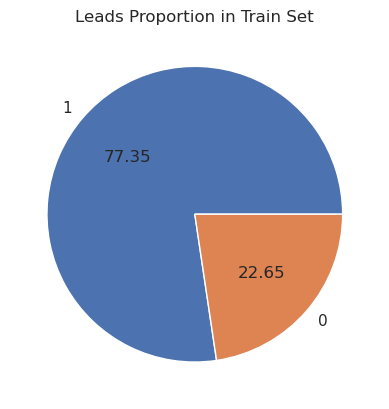

In [ ]:
y_train_cls.value_counts().plot.pie(autopct='%.2f', label='', title = 'Leads Proportion in Train Set')

In [ ]:
y_train_cls.shape

(90264,)

In [ ]:
important_models = [LogisticRegression(), RandomForestClassifier(), XGBClassifier()]

imbalance_techniques = [('Undersampling', RandomUnderSampler()), ('Oversampling', RandomOverSampler()), ('SMOTE', SMOTE())]

results_df = pd.DataFrame(columns=['Model', 'Imbalance Technique', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])

for imbalance_name, imbalance_technique in imbalance_techniques:

    X_train_resampled, y_train_resampled = imbalance_technique.fit_resample(X_train_cls_encoded, y_train_cls)

    for model in important_models:

        model.fit(X_train_resampled, y_train_resampled)

        y_pred = model.predict(X_val_cls_encoded)

        accuracy = accuracy_score(y_val_cls, y_pred)
        precision = precision_score(y_val_cls, y_pred, average='macro')
        recall = recall_score(y_val_cls, y_pred, average='macro')
        f1 = f1_score(y_val_cls, y_pred, average='macro')

        results_df = results_df.append({
            'Model': model.__class__.__name__,
            'Imbalance Technique': imbalance_name,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1
        }, ignore_index=True)

results_df

,Model,Imbalance Technique,Accuracy,Precision,Recall,F1-Score
0,LogisticRegression,Undersampling,0.826243,0.760026,0.805456,0.776559
1,RandomForestClassifier,Undersampling,0.839604,0.781493,0.852423,0.802326
2,XGBClassifier,Undersampling,0.868220,0.811954,0.882087,0.835083
3,LogisticRegression,Oversampling,0.826642,0.760642,0.806770,0.777341
4,RandomForestClassifier,Oversampling,0.843094,0.784506,0.853387,0.805534
5,XGBClassifier,Oversampling,0.874236,0.818018,0.882232,0.840620
6,LogisticRegression,SMOTE,0.826742,0.760573,0.805881,0.777101
7,RandomForestClassifier,SMOTE,0.844257,0.784321,0.847764,0.804913
8,XGBClassifier,SMOTE,0.886068,0.833207,0.866771,0.847739


With both Oversampler and SMOTE all models are performing well... Let's go with SMOTE here...

In [ ]:
smote = SMOTE()
X_train_res, y_train_res = smote.fit_resample(X_train_cls_encoded, y_train_cls)

<Axes: title={'center': 'Leads Proportion in Train Set after Balancing'}>

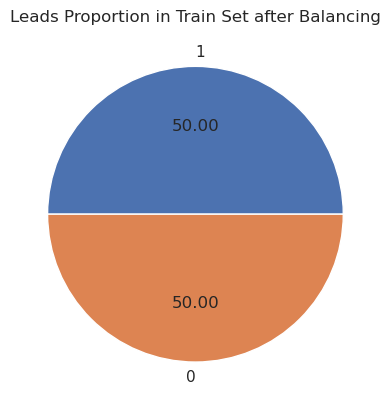

In [ ]:
y_train_res.value_counts().plot.pie(autopct='%.2f', label='', title = 'Leads Proportion in Train Set after Balancing')

In [ ]:
pca_cls = PCA(n_components=32)

X_train_cls_pca = pca_cls.fit_transform(X_train_res)
X_test_cls_pca = pca_cls.transform(X_test_cls_encoded)
X_val_cls_pca = pca_cls.transform(X_val_cls_encoded)

Now, we are all set to build both regression and classification models... Let's move forward...

For regression, we have X_train_pca, X_test_pca, X_val_pca and y_train_reg, y_test_reg, y_val_reg

For classification, we have X_train_cls_pca, X_test_cls_pca, X_val_cls_pca, y_train_res, y_test_cls, y_val_cls

### Finding Best Regression and Classification Model

In [ ]:
regression_models = [
    LinearRegression(),
    Ridge(),
    Lasso(),
    DecisionTreeRegressor(),
    RandomForestRegressor(),
    GradientBoostingRegressor(),
    AdaBoostRegressor(),
    SVR(),
    ElasticNet()
]

reg_results = []

for model in regression_models:
    model_name = model.__class__.__name__
    model.fit(X_train_reg_pca, y_train_reg.ravel())
    y_pred = model.predict(X_val_reg_pca)
    mse = mean_squared_error(y_val_reg, y_pred)
    mae = mean_absolute_error(y_val_reg, y_pred)
    r2 = r2_score(y_val_reg, y_pred)
    reg_results.append({'Model': model_name, 'MSE': mse, 'MAE': mae, 'R2': r2})

reg_results_df = pd.DataFrame.from_records(reg_results)
reg_results_df.sort_values(by='MSE', inplace=True)
reg_results_df

,Model,MSE,MAE,R2
4,RandomForestRegressor,13670.959754,93.359419,0.633491
5,GradientBoostingRegressor,18194.631345,113.766393,0.512215
0,LinearRegression,20075.391639,119.781531,0.461793
1,Ridge,20075.440477,119.781574,0.461792
2,Lasso,20425.940724,120.189277,0.452395
8,ElasticNet,21462.361300,121.608537,0.424610
6,AdaBoostRegressor,22105.782578,128.030485,0.407360
7,SVR,22481.495455,122.248567,0.397287
3,DecisionTreeRegressor,23277.549507,106.710315,0.375946


4 - 0.469576	0.552942	0.525671

8 - 0.384564	0.498495	0.611543

10 - 0.374503	0.491009	0.621707

15 - 0.370979	0.488584	0.625266

25 - 0.363326	0.481468	0.632996

30 - 0.362605	0.480835	0.633725

32 - 0.362602	0.480756	0.633728

33 - 0.362955	0.481035	0.633372

35 - 0.363951	0.481823	0.632365

RF regressor is the good one of all... Let's stick to it and finetune it to get the best out of it...

In [ ]:
classification_models = [
    LogisticRegression(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    XGBClassifier(),
    SVC(),
    KNeighborsClassifier(),
    GaussianNB(),
    LGBMClassifier()
]

cls_results = []

for model in classification_models:
    model_name = model.__class__.__name__
    model.fit(X_train_cls_pca, y_train_res)
    y_pred = model.predict(X_val_cls_pca)
    accuracy = accuracy_score(y_val_cls, y_pred)
    precision = precision_score(y_val_cls, y_pred, average='macro')
    recall = recall_score(y_val_cls, y_pred, average='macro')
    f1 = f1_score(y_val_cls, y_pred, average='macro')
    roc_auc = roc_auc_score(y_val_cls, y_pred)
    cls_results.append({'Model': model_name, 'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1-Score': f1, 'ROC-AUC': roc_auc})

cls_results_df = pd.DataFrame.from_records(cls_results)
cls_results_df.sort_values(by='F1-Score', ascending=False, inplace=True)
cls_results_df

,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC
2,RandomForestClassifier,0.898597,0.847764,0.893507,0.866616,0.893507
1,DecisionTreeClassifier,0.883841,0.832262,0.852564,0.841604,0.852564
5,XGBClassifier,0.876496,0.820138,0.874409,0.840743,0.874409
9,LGBMClassifier,0.853629,0.794081,0.854463,0.814850,0.854463
7,KNeighborsClassifier,0.853197,0.792962,0.849309,0.812992,0.849309
6,SVC,0.844157,0.784163,0.847398,0.804722,0.847398
4,GradientBoostingClassifier,0.834186,0.771160,0.825893,0.789858,0.825893
0,LogisticRegression,0.826808,0.760599,0.805673,0.777078,0.805673
3,AdaBoostClassifier,0.811652,0.744988,0.794961,0.761577,0.794961
8,GaussianNB,0.787457,0.701703,0.703976,0.702819,0.703976


With respect to classification as well, RF is performing well... So, let's stick to it and fine tune to improve the performance of the model...

### Hyperparameter Tuning for Both Regression and Classification

In [ ]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

rf_regressor = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(estimator=rf_regressor, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train_reg_pca, y_train_reg)

print("Best Parameters: ", grid_search.best_params_)
print("Best Score (Negative MSE): ", grid_search.best_score_)

Best Parameters:  {'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Best Score (Negative MSE):  -16745.30750855892


In [ ]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}


rf_classifier = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_cls_pca, y_train_res)

print("Best Parameters: ", grid_search.best_params_)
print("Best Score (Accuracy): ", grid_search.best_score_)

Best Parameters:  {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best Score (Accuracy):  0.9424680276609656


In [ ]:
# # Convert DataFrame variables to numpy arrays
# X_train_res = X_train_res.values if isinstance(X_train_res, pd.DataFrame) else X_train_res
# X_test_cls_encoded = X_test_cls_encoded.values if isinstance(X_test_cls_encoded, pd.DataFrame) else X_test_cls_encoded
# X_val_cls_encoded = X_val_cls_encoded.values if isinstance(X_val_cls_encoded, pd.DataFrame) else X_val_cls_encoded


# Convert Series variables to numpy arrays
y_train_reg = y_train_reg.values if isinstance(y_train_reg, pd.Series) else y_train_reg
y_test_reg = y_test_reg.values if isinstance(y_test_reg, pd.Series) else y_test_reg
y_val_reg = y_val_reg.values if isinstance(y_val_reg, pd.Series) else y_val_reg

y_train_res = y_train_res.values if isinstance(y_train_res, pd.Series) else y_train_res
y_test_cls = y_test_cls.values if isinstance(y_test_cls, pd.Series) else y_test_cls
y_val_cls = y_val_cls.values if isinstance(y_val_cls, pd.Series) else y_val_cls

### Building Regression Model

In [ ]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

best_params = {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}

reg_model = RandomForestRegressor(
    max_depth=best_params['max_depth'],
    max_features=best_params['max_features'],
    min_samples_leaf=best_params['min_samples_leaf'],
    min_samples_split=best_params['min_samples_split'],
    n_estimators=best_params['n_estimators']
)

# Fit the model on the training data
reg_model.fit(X_train_reg_pca, y_train_reg)

y_pred_reg = reg_model.predict(X_val_reg_pca)

# Calculate regression metrics directly on scaled values
reg_mse = mean_squared_error(y_val_reg, y_pred_reg)
reg_mae = mean_absolute_error(y_val_reg, y_pred_reg)
reg_r2 = r2_score(y_val_reg, y_pred_reg)

# Calculate the percentage difference between training and validation MSE directly on scaled values
y_train_pred_reg = reg_model.predict(X_train_reg_pca)
train_mse = mean_squared_error(y_train_reg, y_train_pred_reg)
mse_diff_percentage = (train_mse - reg_mse) / train_mse * 100

print("Regression Metrics:")
print(f"MSE: {reg_mse}")
print(f"MAE: {reg_mae}")
print(f"R2: {reg_r2}")

print("Percentage Difference between Training and Validation MSE:")
print(f"MSE Difference: {mse_diff_percentage:.2f}%")

Regression Metrics:
MSE: 16336.215697452251
MAE: 107.5024780309772
R2: 0.5620378987850025
Percentage Difference between Training and Validation MSE:
MSE Difference: -8.45%


Not upto the mark even after doing so many things that we could probably do... Let's check whether the problem is with the dataset or what...

In [ ]:
correlation = encoded_df.corr()

num_features_greater_than_0_5 = sum((correlation > 0.5).sum() > 1)

total_features = len(encoded_df.columns)
percentage_greater_than_0_5 = (num_features_greater_than_0_5 / total_features) * 100

print(f"Number of features with correlation > 0.5: {num_features_greater_than_0_5}")
print(f"Percentage of features with correlation > 0.5: {percentage_greater_than_0_5:.2f}%")

Number of features with correlation > 0.5: 2
Percentage of features with correlation > 0.5: 3.64%


Yes, ofcourse... It seems the problem is with the dataset as only 2 features has correlation greater than 0.5... So, let's leave it as it is...

Now let's move on and build classification model...

### Building Classification Model

In [ ]:
best_params_cls = {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

cls_model = RandomForestClassifier(
    max_depth=best_params['max_depth'],
    max_features=best_params['max_features'],
    min_samples_leaf=best_params['min_samples_leaf'],
    min_samples_split=best_params['min_samples_split'],
    n_estimators=best_params['n_estimators'])

cls_model.fit(X_train_cls_pca, y_train_res)

y_pred_cls = cls_model.predict(X_val_cls_pca)

cls_accuracy = accuracy_score(y_val_cls, y_pred_cls)
cls_precision = precision_score(y_val_cls, y_pred_cls, average='macro')
cls_recall = recall_score(y_val_cls, y_pred_cls, average='macro')
cls_f1 = f1_score(y_val_cls, y_pred_cls, average='macro')

cls_roc_auc = roc_auc_score(y_val_cls, y_pred_cls)

train_accuracy = accuracy_score(y_train_res, cls_model.predict(X_train_cls_pca))
accuracy_diff_percentage = (train_accuracy - cls_accuracy) / train_accuracy * 100

print("Classification Metrics:")
print(f"Accuracy: {cls_accuracy}")
print(f"Precision: {cls_precision}")
print(f"Recall: {cls_recall}")
print(f"F1-Score: {cls_f1}")
print(f"ROC AUC Score: {cls_roc_auc}")
print("Percentage Difference between Training and Validation Accuracy:")
print(f"Accuracy Difference: {accuracy_diff_percentage:.2f}%")

Classification Metrics:
Accuracy: 0.8610077107152353
Precision: 0.8018537209352605
Recall: 0.8569513818082652
F1-Score: 0.822007483730806
ROC AUC Score: 0.8569513818082652
Percentage Difference between Training and Validation Accuracy:
Accuracy Difference: 3.76%


In [ ]:
print(f'Confusion Matrix:\n\n {confusion_matrix(y_val_cls, y_pred_cls)}')

Confusion Matrix:

 [[ 5911  1048]
 [ 3134 19995]]


### Dumping Encoders, Scalers and Models as Pickle File

In [ ]:
joblib.dump(target_encoder_reg, 'te_reg.pkl')
joblib.dump(target_encoder_cls, 'te_cls.pkl')
joblib.dump(scaler_reg, 'scaler_reg.pkl')
joblib.dump(scaler_cls, 'scaler_cls.pkl')
joblib.dump(pca_reg, 'pca_reg.pkl')
joblib.dump(pca_cls, 'pca_cls.pkl')
joblib.dump(reg_model, 'reg_model.pkl')
joblib.dump(cls_model, 'cls_model.pkl')

['cls_model.pkl']